# 강수량과 지하철 승하차 인구 관계 

* '맑음' 일때 지하철 이용객 수가 가장 많다.
* 소우 ~ 폭우까지는 모든 호선이 비가 많이 올 수록 이용 인구가 줄어든다.
    * 폭우시 지하철보다 다른 교통수단(택시, 자가용)을 선호하는 것으로 보인다. 비오는날 택시 수요가 늘어난다는 기사 캡쳐해서 발표자료에 넣어주세요<br><br>

* 그러므로 '비하인드' 서비스가 있으면 공유 우산으로 비가오는 날에도 지하철을 많이 아용하게 만들 수 있다.
    * 집까지 가는 길이 평소엔 지하철이어도 비가오면 다른 수단을 이용하는 것이니, 평소에 이용하는 사람들에게 공유우산을 제공하면 비가 와도 택시를 이용하지 않고 지하철을 이용할 수 있다.<br><br>

* 이렇게 함으로서, 우리 조의 목표인 환경보호에도 해결 가능

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

# 파일 경로
file_path_rain = '서울강수정보_2023.csv'
file_path_subway = '서울교통공사_역별 일별 시간대별 승하차인원 정보_2023.csv'
file_path_snow = '서울눈일수_2023.csv'

# 파일 읽기 (encoding 설정 변경)
rain_data = pd.read_csv(file_path_rain, encoding='utf-8')
subway_data = pd.read_csv(file_path_subway, encoding='utf-8')
snow_data = pd.read_csv(file_path_snow, encoding='utf-8')

In [2]:
# 강수량 범주 설정
def categorize_rainfall(amount):
    if 0 < amount < 1:
        return '소우'
    elif 1 <= amount < 5:
        return '중우'
    elif 5 <= amount < 12:
        return '대우'
    elif 12 <= amount < 1000:
        return '폭우'
    else:
        return '맑음'

rain_data['강수형태'] = rain_data['일강수량(mm)'].apply(categorize_rainfall)

In [3]:
rain_data.loc[rain_data["일시"].isin(snow_data["일시"]), "강수형태"] = "눈"

In [4]:
rain_data['강수형태'].value_counts()

강수형태
맑음    244
폭우     34
중우     30
눈      25
소우     17
대우     15
Name: count, dtype: int64

In [5]:
rain_data.rename(columns={'일시': '날짜'}, inplace=True)

In [6]:
# 필요한 열 선택 및 날짜 형식 통일
rain_data['날짜'] = pd.to_datetime(rain_data['날짜'])
subway_data['날짜'] = pd.to_datetime(subway_data['날짜'])

# 날짜를 기준으로 데이터 병합
merged_data = pd.merge(subway_data, rain_data, on='날짜')

# 승차와 하차 인원을 구분하기 위해 데이터를 분리하고, 각각의 총인원을 계산
승차_data = merged_data[merged_data['구분'] == '승차'].copy()
하차_data = merged_data[merged_data['구분'] == '하차'].copy()

# 시간대별 합산 인원 계산
승차_data['총인원'] = 승차_data.loc[:, '06시 이전':'24시 이후'].sum(axis=1)
하차_data['총인원'] = 하차_data.loc[:, '06시 이전':'24시 이후'].sum(axis=1)

# 호선별 강수량에 따른 승차 인원 평균 계산
호선_승차_grouped = 승차_data.groupby(['호선', '강수형태'])['총인원'].mean().unstack()
호선_하차_grouped = 하차_data.groupby(['호선', '강수형태'])['총인원'].mean().unstack()

호선_승하차_grouped = (호선_승차_grouped + 호선_하차_grouped) / 2

# 전체 호선 강수량에 따른 승하차 인원 평균 계산
전체_승차_grouped = 승차_data.groupby('강수형태')['총인원'].mean().reset_index(name='평균 승차 인원')
전체_하차_grouped = 하차_data.groupby('강수형태')['총인원'].mean().reset_index(name='평균 하차 인원')

전체_승하차_grouped = pd.merge(전체_승차_grouped, 전체_하차_grouped, on="강수형태")
전체_승하차_grouped["평균 승하차 인원"] = (전체_승하차_grouped["평균 승차 인원"] + 전체_승하차_grouped["평균 하차 인원"]) / 2
전체_승하차_grouped = 전체_승하차_grouped[["강수형태", "평균 승차 인원", "평균 하차 인원", "평균 승하차 인원"]]

In [7]:
new_order = ["눈", "맑음", "소우", "중우", "대우", "폭우"]
호선_승하차_grouped = 호선_승하차_grouped[new_order]
호선_승하차_grouped

강수형태,눈,맑음,소우,중우,대우,폭우
호선,,,,,,
1호선,21382.082000,23369.988934,23015.517647,22906.298333,22665.796667,21596.711765
2호선,24773.858000,26874.118156,26727.907647,26426.498667,26566.678000,25456.152059
3호선,13870.906475,15407.332776,15263.838078,15197.929940,15026.301000,14508.637778
4호선,17558.664615,19159.656132,18913.168552,18931.662821,18840.614103,17966.079186
5호선,10108.750357,11148.127964,11068.705882,10954.131845,11066.377976,10550.003676
6호선,7850.022114,8826.138622,8669.556439,8700.140991,8757.599641,8320.376190
7호선,11921.386667,13406.665610,13304.488796,13204.279365,13267.900000,12611.402661
8호선,9480.264444,10260.031079,10172.602941,10128.345370,10249.129630,9810.174837


In [8]:
전체_승하차_grouped = 전체_승하차_grouped.set_index("강수형태").loc[new_order].reset_index()
전체_승하차_grouped

,강수형태,평균 승차 인원,평균 하차 인원,평균 승하차 인원
0,눈,14305.676112,14326.567905,14316.122009
1,맑음,15767.933156,15719.224446,15743.578801
2,소우,15677.910486,15531.619243,15604.764865
3,중우,15557.869885,15444.697501,15501.283693
4,대우,15578.615610,15488.499878,15533.557744
5,폭우,14938.747109,14761.104399,14849.925754


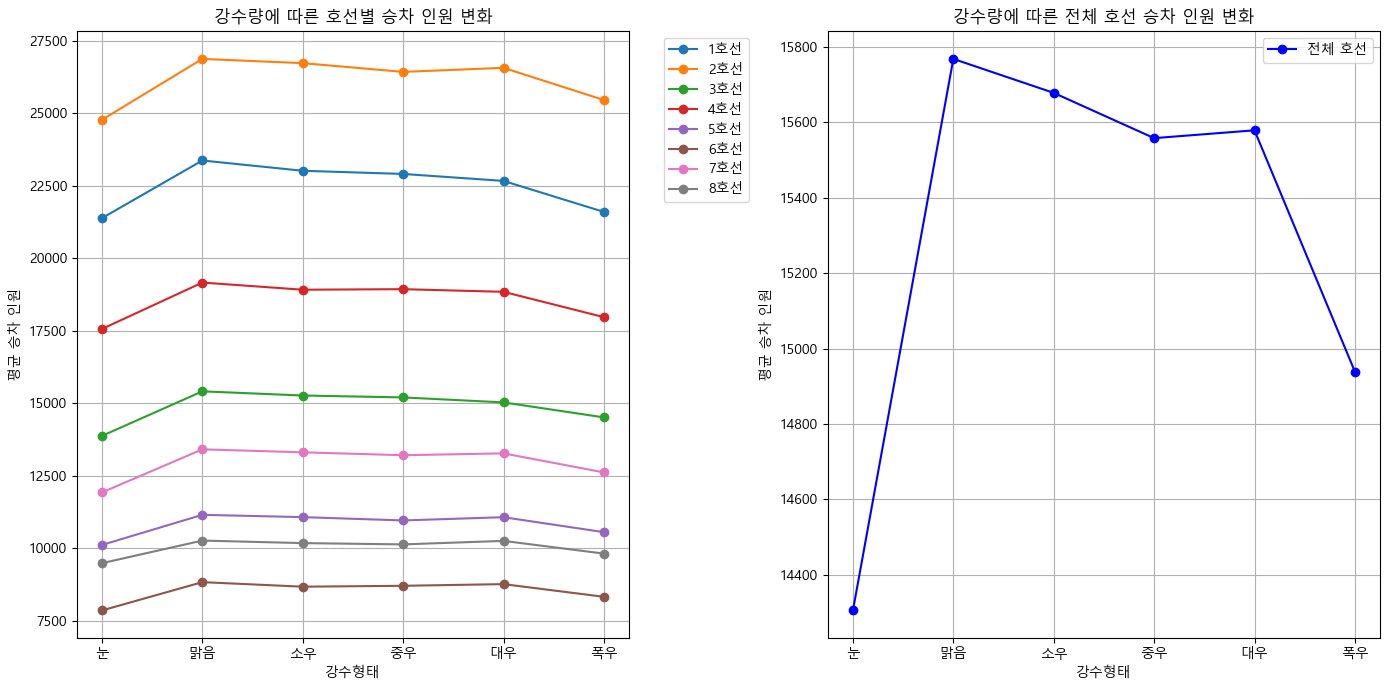

In [9]:
# 시각화
plt.figure(figsize=(14, 7))

# 호선별 강수량에 따른 승차 인원 변화
plt.subplot(1, 2, 1)
for 호선 in 호선_승하차_grouped.index:
    plt.plot(호선_승하차_grouped.columns, 호선_승하차_grouped.loc[호선], marker='o', label=f'{호선}')
plt.title('강수량에 따른 호선별 승차 인원 변화')
plt.xlabel('강수형태')
plt.ylabel('평균 승차 인원')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 전체 호선 강수량에 따른 승차 인원 변화
plt.subplot(1, 2, 2)
plt.plot(전체_승하차_grouped['강수형태'], 전체_승하차_grouped['평균 승차 인원'], marker='o', color='blue', label='전체 호선')
plt.title('강수량에 따른 전체 호선 승차 인원 변화')
plt.xlabel('강수형태')
plt.ylabel('평균 승차 인원')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()